# Определение перспективного тарифа для телеком-компании

`Цель:` Компании «N» необходимо скорректировать рекламный бюджет, для этого нужн выяснить какой тариф («Смарт» или «Ультра») приносит больше денег.

`Данные:` В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
 
`Задача:` Необходимо проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

`План работы:`

- загрузка и изучение данных
- предобработка
- исследование данных
- проверка гипотез
- вывод 

`Гипотезы:`
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

`Входные данные:`

- /datasets/calls.csv 
- /datasets/internet.csv 
- /datasets/messages.csv 
- /datasets/tariffs.csv 
- /datasets/users.csv 

## Изучение данных 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math

In [2]:
calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")

In [3]:
#calls.info()
#internet.info()
#messages.info() 
#tariffs.info() 
users.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
calls.head()
#internet.head()
#messages.head(100) 
#tariffs.head() 
#users.head() 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
#calls.describe()
#internet.describe()
#messages.describe() 
tariffs.describe() 
#users.describe() 

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


### Описание данных
Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

предварительный вывод: 
В таблице calls
- проверить есть ли другие id, кроме 1000

В таблицеmessages
- проверить есть ли другие id, кроме 1000

В таблице users
- проверить дубликаты


Стоит изменить тип данных в столбцах:

- call_date session_date
- message_date
- churn_date
- reg_date

## Предобработка данных

### Пропуски в данных

Посчитаем сколько в таблицах пропущенных значений.

In [6]:
calls.isna().sum()
internet.isna().sum()
messages.isna().sum()
tariffs.isna().sum()
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропуски есть только в таблице users, в столбце churn_date. Их заполнять не нужно тк пропуски в этом столбце означает что тариф ещё действовал на момент выгрузки данных.

In [7]:
df_list = [calls, internet, messages, tariffs, users]
df_name_list = ['calls', 'internet', 'messages', 'tariffs', 'users']

for i in range(len(df_list)):
    print(df_name_list[i])
    print(df_list[i].isna().sum())
    print()

calls
id           0
call_date    0
duration     0
user_id      0
dtype: int64

internet
Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

messages
id              0
message_date    0
user_id         0
dtype: int64

tariffs
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

users
user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64



### Дубликаты

In [9]:
df_list = [calls, internet, messages, tariffs, users]
df_name_list = ['calls', 'internet', 'messages', 'tariffs', 'users']

for i in range(len(df_list)):
    print(df_name_list[i])
    print(df_list[i].duplicated().sum())
    print()

calls
0

internet
0

messages
0

tariffs
0

users
0



Явных дубликатов нет.

###  Изменение типов данных. 

In [10]:
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%dT%H:%M:%S')#
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y-%m-%dT%H:%M:%S')

calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%dT%H:%M:%S')#

internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%dT%H:%M:%S')#

messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%dT%H:%M:%S')#


In [11]:
calls.info() # Проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


###  Проверка данных на аномалии

Проверим количественные переменные (age, duration, mb_used, значаения в таблице tariffs) на:
- выбросы с отрицательным значением
- выбросы со слишком большим значением


Из первого пункта (метод describe) известно:

- минимальное значение в столбце duration = 0, что не является аномалией, а означает пропущенные звонки.
- максимальное значение в столбце duration = 38, также не аномалия
- минимальное и максимальное значения возраста пользователей риемлемые -  18 и 75
- c переменной mb_used также все в норме
-  в таблице tariffs также отсутствуют отрицательные или аномально большие значения

Проверим, что звонки и сообщения были отправлены разными пользователями

In [12]:
#len(users["user_id"].unique())
#len(calls["user_id"].unique())
len(messages["user_id"].unique())

426

### Дополнительные расчеты

Необходимо посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-- - трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [13]:
calls['duration'] 

0          0.00
1          0.00
2          2.85
3         13.80
4          5.18
          ...  
202602     0.76
202603    18.83
202604    10.81
202605     4.27
202606    19.62
Name: duration, Length: 202607, dtype: float64

In [14]:
duration_round = []

for val in calls['duration']:
    duration_round.append(math.ceil(val))
    
calls['duration_round'] = duration_round
calls['duration_round']

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration_round, Length: 202607, dtype: int64

In [15]:
# создадим отдельно столбцы с месяцами
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [58]:
calls.head()

,id,call_date,duration,user_id,duration_round,month
0,1000_0,2018-07-25,0.00,1000,0,7
1,1000_1,2018-08-17,0.00,1000,0,8
2,1000_2,2018-06-11,2.85,1000,3,6
3,1000_3,2018-09-21,13.80,1000,14,9
4,1000_4,2018-12-15,5.18,1000,6,12


In [16]:
# создадим сводные таблицы с необходимыми данными, по длительности звонков, кол-ве сообщений и использованных мб
calls_pivot = calls.pivot_table(index = ["user_id","month"],values = "duration_round",aggfunc = ["count","sum"])
messages_pivot = messages.pivot_table(index = ["user_id","month"],values = "id",aggfunc = "count")
internet_pivot = internet.pivot_table(index = ["user_id","month"],values = "mb_used",aggfunc = "sum")
internet_pivot['mb_used'].isna().sum()
#messages_pivot

0

In [17]:
df_month = calls_pivot.join([messages_pivot,internet_pivot], how = 'outer')
df_month['mb_used'].isna().sum()
#df_month.head(10)

11

In [18]:
#заполним пропуски
df_month[df_month['mb_used'].isna()==True] = 0
df_month['mb_used'].isna().sum()

# Перевод в GB
df_month['gb_used'] = df_month['mb_used']/1024

df_month

(count, duration_round)  (sum, duration_round)    id   mb_used  \
user_id month                                                                   
1000    5                         22.0                  159.0  22.0   2253.49   
        6                         43.0                  172.0  60.0  23233.77   
        7                         47.0                  340.0  75.0  14003.64   
        8                         52.0                  408.0  81.0  14055.93   
        9                         58.0                  466.0  57.0  14568.91   
...                                ...                    ...   ...       ...   
1498    10                        41.0                  247.0  42.0  20579.36   
1499    9                          9.0                   70.0  11.0   1845.75   
        10                        68.0                  449.0  48.0  17788.51   
        11                        74.0                  612.0  59.0  17963.31   
        12                        69.0                  492.0  66.0  13055.58   

                 gb_used  
user_id month             
1000    5       2.200674  
        6      22.689229  
        7      13.675430  
        8      13.726494  
        9      14.227451  
...                  ...  
1498    10     20.097031  
1499    9       1.802490  
        10     17.371592  
        11     17.542295  
        12     12.749590  

[3214 rows x 5 columns]

In [19]:
gb_round = []

for val in df_month['gb_used']:
    gb_round.append(math.ceil(val))
    
df_month['gb_round'] = gb_round


In [20]:
df_month.columns = list(map("".join, df_month.columns))
df_month

countduration_round  sumduration_round    id   mb_used  \
user_id month                                                           
1000    5                     22.0              159.0  22.0   2253.49   
        6                     43.0              172.0  60.0  23233.77   
        7                     47.0              340.0  75.0  14003.64   
        8                     52.0              408.0  81.0  14055.93   
        9                     58.0              466.0  57.0  14568.91   
...                            ...                ...   ...       ...   
1498    10                    41.0              247.0  42.0  20579.36   
1499    9                      9.0               70.0  11.0   1845.75   
        10                    68.0              449.0  48.0  17788.51   
        11                    74.0              612.0  59.0  17963.31   
        12                    69.0              492.0  66.0  13055.58   

                 gb_used  gb_round  
user_id month                       
1000    5       2.200674         3  
        6      22.689229        23  
        7      13.675430        14  
        8      13.726494        14  
        9      14.227451        15  
...                  ...       ...  
1498    10     20.097031        21  
1499    9       1.802490         2  
        10     17.371592        18  
        11     17.542295        18  
        12     12.749590        13  

[3214 rows x 6 columns]

In [21]:
month = []
for i in range(len(df_month)):
    month.append(df_month.index[i][1])

df_month['month'] = month

In [22]:
df_all = users.merge(df_month,on='user_id',how = 'outer')
df_all.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,countduration_round,sumduration_round,id,mb_used,gb_used,gb_round,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.0,159.0,22.0,2253.49,2.200674,3.0,5.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.0,172.0,60.0,23233.77,22.689229,23.0,6.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,47.0,340.0,75.0,14003.64,13.675430,14.0,7.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,52.0,408.0,81.0,14055.93,13.726494,14.0,8.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,58.0,466.0,57.0,14568.91,14.227451,15.0,9.0


In [23]:
df_all = df_all.rename(columns={"tariff": "tariff_name"})

In [24]:
df_all.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,countduration_round,sumduration_round,id,mb_used,gb_used,gb_round,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.0,159.0,22.0,2253.49,2.200674,3.0,5.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.0,172.0,60.0,23233.77,22.689229,23.0,6.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,47.0,340.0,75.0,14003.64,13.675430,14.0,7.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,52.0,408.0,81.0,14055.93,13.726494,14.0,8.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,58.0,466.0,57.0,14568.91,14.227451,15.0,9.0


In [25]:
# Объеденим таблицы


df_all = df_all.merge(tariffs,on='tariff_name',how = 'left')
df_all.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,countduration_round,sumduration_round,...,gb_used,gb_round,month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.0,159.0,...,2.200674,3.0,5.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.0,172.0,...,22.689229,23.0,6.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,47.0,340.0,...,13.675430,14.0,7.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,52.0,408.0,...,13.726494,14.0,8.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,58.0,466.0,...,14.227451,15.0,9.0,1000,30720,3000,1950,150,1,1


In [26]:
# считаем разницу между использованными и предоставляемыми тарифом ресурсы

df_all['differences_cals'] = df_all['sumduration_round'] - df_all['minutes_included']
df_all['differences_messages'] = df_all['id'] - df_all['messages_included']
df_all['differences_internet'] = df_all['gb_round'] - df_all['mb_per_month_included']/1024


df_all

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,countduration_round,sumduration_round,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,differences_cals,differences_messages,differences_internet
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.0,159.0,...,1000,30720,3000,1950,150,1,1,-2841.0,-978.0,-27.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.0,172.0,...,1000,30720,3000,1950,150,1,1,-2828.0,-940.0,-7.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,47.0,340.0,...,1000,30720,3000,1950,150,1,1,-2660.0,-925.0,-16.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,52.0,408.0,...,1000,30720,3000,1950,150,1,1,-2592.0,-919.0,-16.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,58.0,466.0,...,1000,30720,3000,1950,150,1,1,-2534.0,-943.0,-15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,41.0,247.0,...,50,15360,500,550,200,3,3,-253.0,-8.0,6.0
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,70.0,...,50,15360,500,550,200,3,3,-430.0,-39.0,-13.0
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,68.0,449.0,...,50,15360,500,550,200,3,3,-51.0,-2.0,3.0
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,74.0,612.0,...,50,15360,500,550,200,3,3,112.0,9.0,3.0


In [27]:
# Считаем оплату за разницу
df_all['calls_income'] = df_all[df_all['differences_cals'] > 0]['differences_cals'] * df_all['rub_per_minute']
df_all['messages_income'] = df_all[df_all['differences_messages'] > 0]['differences_messages'] * df_all['rub_per_message']
df_all['internet_income'] = df_all[df_all['differences_internet'] > 0]['differences_internet'] * df_all['rub_per_gb']

df_all[df_all['differences_cals'] > 0]


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,countduration_round,sumduration_round,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,differences_cals,differences_messages,differences_internet,calls_income,messages_income,internet_income
32,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,77.0,606.0,...,550,200,3,3,106.0,6.0,-4.0,318.0,18.0,NaN
33,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,101.0,712.0,...,550,200,3,3,212.0,-9.0,-5.0,636.0,NaN,NaN
34,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,73.0,595.0,...,550,200,3,3,95.0,-8.0,-7.0,285.0,NaN,NaN
35,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,80.0,612.0,...,550,200,3,3,112.0,-3.0,-5.0,336.0,NaN,NaN
36,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,77.0,569.0,...,550,200,3,3,69.0,6.0,-7.0,207.0,18.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,88.0,527.0,...,550,200,3,3,27.0,-9.0,8.0,81.0,NaN,1600.0
3203,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,80.0,662.0,...,550,200,3,3,162.0,-4.0,10.0,486.0,NaN,2000.0
3204,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,80.0,518.0,...,550,200,3,3,18.0,1.0,6.0,54.0,3.0,1200.0
3207,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,71.0,545.0,...,550,200,3,3,45.0,-33.0,5.0,135.0,NaN,1000.0


In [28]:
df_all['calls_income'] = df_all['calls_income'].fillna(0)
df_all['messages_income'] = df_all['messages_income'].fillna(0)
df_all['internet_income'] = df_all['internet_income'].fillna(0)

#df_all

In [29]:
# Посчитаем общую прибыль с каждого пользователя за каждый месяц
df_all['total_income'] = df_all['rub_monthly_fee'] + df_all['calls_income'] + df_all['messages_income']+df_all['internet_income']

In [30]:
df_all.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,countduration_round,sumduration_round,...,rub_per_gb,rub_per_message,rub_per_minute,differences_cals,differences_messages,differences_internet,calls_income,messages_income,internet_income,total_income
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,22.0,159.0,...,150,1,1,-2841.0,-978.0,-27.0,0.0,0.0,0.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,43.0,172.0,...,150,1,1,-2828.0,-940.0,-7.0,0.0,0.0,0.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,47.0,340.0,...,150,1,1,-2660.0,-925.0,-16.0,0.0,0.0,0.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,52.0,408.0,...,150,1,1,-2592.0,-919.0,-16.0,0.0,0.0,0.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,58.0,466.0,...,150,1,1,-2534.0,-943.0,-15.0,0.0,0.0,0.0,1950.0


## Исследование данных

In [31]:
# сводные таблицы для каждого тарифа
ultra = df_all.query('tariff_name == "ultra"').pivot_table(index = ["user_id","month"],values = ["sumduration_round",'id','gb_round','total_income'])
smart = df_all.query('tariff_name == "smart"').pivot_table(index = ["user_id","month"],values =  ["sumduration_round",'id','gb_round','total_income'])


Построим гистограммы по каждому параметру и сравним тарифы

<AxesSubplot:>

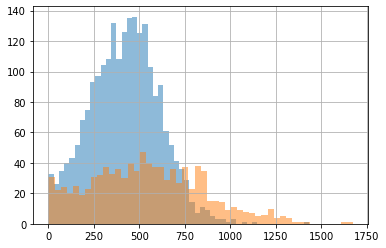

In [32]:
smart['sumduration_round'].hist(bins = 50, alpha=0.5) #  blue
ultra['sumduration_round'].hist(bins = 50, alpha=0.5)

<AxesSubplot:>

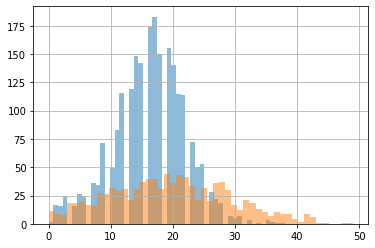

In [33]:
smart['gb_round'].hist(bins = 50, alpha=0.5) #  blue
ultra['gb_round'].hist(bins = 50, alpha=0.5)

<AxesSubplot:>

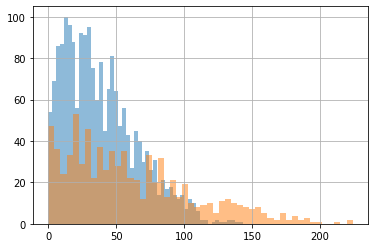

In [34]:
smart['id'].hist(bins = 50, alpha=0.5) #  blue
ultra['id'].hist(bins = 50, alpha=0.5)

<AxesSubplot:>

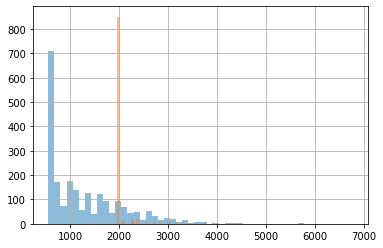

In [35]:
smart['total_income'].hist(bins = 50, alpha=0.5) #  blue
ultra['total_income'].hist(bins = 50, alpha=0.5)

### Исследование тарифа Ultra

Тариф «Ультра»

Ежемесячная плата: 1950 рублей

- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

#### Звонки

In [36]:
m = ultra['sumduration_round'].mean() #Среднее
m

543.1188222923239

In [37]:
d = ultra['sumduration_round'].var() # Дисперсия

In [38]:
std = np.sqrt(d)   # стандартное отклонение
std

310.10291937233217

###### По правилу трех сигм 99% удовлетворит  (среднее) + 3* (стандартное отклонение)

In [39]:
m+3*std

1473.4275804093204

###### Вывод 
1500 минут удовлетворит 99% пользователей при 3000 включенных в пакет.

#### Интернет

In [40]:
m = ultra['gb_round'].mean() #Среднее
d = ultra['gb_round'].var() # Дисперсия
std = np.sqrt(d)   # стандартное отклонение
m+3*std

49.054950346185706

In [41]:
m

19.494416243654822

###### Вывод 
По правилу трех сигм 99% удовлетворит 50 Gb, в тариф включено 30 гб.

#### Сообщения

In [42]:
m = ultra['id'].mean() #Среднее
d = ultra['id'].var() # Дисперсия
std = np.sqrt(d)   # стандартное отклонение
m+3*std

199.598578407182

In [43]:
m

60.8125786163522

###### Вывод
200 сообщений удовлетворит 99% пользователей, 1000 включено в тариф.

### Исследование тарифа Smart

Тариф «Смарт»

Ежемесячная плата: 550 рублей

- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика


Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

#### Звонки

In [44]:
m = smart['sumduration_round'].mean() #Среднее
d = smart['sumduration_round'].var() # Дисперсия
std = np.sqrt(d)   # стандартное отклонение
m+3*std

987.1578265917095

In [45]:
m

419.0404858299595

1000 минут удовлетворит 99% пользователей, 500 в тарифе

#### Сообщения

In [46]:
m = smart['id'].mean() #Среднее
d = smart['id'].var() # Дисперсия
std = np.sqrt(d)   # стандартное отклонение
m+3*std

119.08199523050271

In [47]:
m

38.7159209157128

120 сообщений удовлетворит 99% пользователей, 50 в тарифе

#### Интернет

In [48]:
m = smart['gb_round'].mean() #Среднее
d = smart['gb_round'].var() # Дисперсия
std = np.sqrt(d)   # стандартное отклонение
m+3*std

33.57002872212654

In [49]:
m

16.328847016599372

 33 Gb удовлетворит 99% пользователей, 15 включено.

## Проверка гипотез
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

###  Гипотеза №1

H0 - средняя выручка, полученная от пользователей тарифов «Ультра» и «Смарт» равна

H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются



In [50]:
ultra['total_income'].mean()

2070.1522842639592

In [51]:
smart['total_income'].mean()

1289.9735307312696

In [52]:
alpha = .01

results = st.ttest_ind(
    ultra['total_income'], 
    smart['total_income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


###### Гипотеза №1 
Вывод: оба способа сравнить средние, говорят о различной прибыли на двух тарифах.

###  Гипотеза №2

H0 - средняя выручка пользователей из Москвы и пользователей из других регионов равна

H1 - средняя выручка пользователей различается

In [53]:
data_moscow = df_all.query('city == "Москва"').pivot_table(index = ["user_id","month"],values = ["sumduration_round",'id','gb_round','total_income'])
data_moscow

gb_round    id  sumduration_round  total_income
user_id month                                                 
1001    11.0       18.0   NaN              430.0        1150.0
        12.0       14.0   NaN              414.0         550.0
1003    8.0         9.0  37.0              380.0        1950.0
        9.0        13.0  91.0              961.0        1950.0
        10.0       15.0  83.0              855.0        1950.0
...                 ...   ...                ...           ...
1490    8.0        17.0  50.0              346.0         950.0
        9.0        15.0  48.0              322.0         550.0
        10.0       21.0  45.0              312.0        1750.0
        11.0       19.0  47.0              282.0        1350.0
        12.0       16.0  46.0              290.0         750.0

[611 rows x 4 columns]

In [54]:
data_other  = df_all.query('city != "Москва"').pivot_table(index = ["user_id","month"],values = ["sumduration_round",'id','gb_round','total_income'])
data_other

gb_round    id  sumduration_round  total_income
user_id month                                                 
1000    5.0         3.0  22.0              159.0        1950.0
        6.0        23.0  60.0              172.0        1950.0
        7.0        14.0  75.0              340.0        1950.0
        8.0        14.0  81.0              408.0        1950.0
        9.0        15.0  57.0              466.0        1950.0
...                 ...   ...                ...           ...
1498    10.0       21.0  42.0              247.0        1750.0
1499    9.0         2.0  11.0               70.0         550.0
        10.0       18.0  48.0              449.0        1150.0
        11.0       18.0  59.0              612.0        1513.0
        12.0       13.0  66.0              492.0         598.0

[2603 rows x 4 columns]

In [55]:
alpha = .01

results = st.ttest_ind(
    data_moscow['total_income'], 
    data_other['total_income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


In [56]:
data_moscow['total_income'].mean()

1546.7135842880523

In [57]:
data_other['total_income'].mean()

1524.9362274298885

###### Гипотеза №2 

Вывод: средняя выручка пользователей из Москвы и пользователей из других регионов равна

## Вывод

Каждый из тарифов перекрывает потребности своего среднего пользователя, но

- Тариф ULTRA предоставляет в 2 раза больше минут и сообщений, чем требуется, чтобы покрыть 99% пользователей и в 1,5 меньше Gb интернета.

- Тариф SMART предоставляет ~2 раза меньше, чем необходимо по всем трем пунктам, чтобы покрыть 99% пользователей. 


Вывод по предложенным гипотезам: доход Мосвы и регионов не отличается, а вот доход от разных тарифов различается, практически в два раза.